In [26]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from safetensors.torch import save_model

In [27]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

### Data Processing

In [28]:
df = pd.read_csv('signs_en.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,Landmark 4 x,Landmark 4 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
0,0,0.0,0.447142,0.590708,0.469595,0.513098,0.471293,0.451205,0.455870,0.405068,...,0.630833,0.518164,0.645377,0.555401,0.660619,0.535724,0.671495,0.516766,0.669519,good
1,1,1.0,0.447354,0.598270,0.470890,0.518473,0.474211,0.456242,0.458783,0.407200,...,0.634632,0.518493,0.648955,0.557850,0.663069,0.536107,0.673253,0.514505,0.670299,good
2,2,2.0,0.447751,0.594389,0.471821,0.516508,0.474668,0.455287,0.459516,0.407649,...,0.634539,0.519102,0.647704,0.561070,0.663423,0.539275,0.672495,0.516909,0.668556,good
3,3,3.0,0.447579,0.594926,0.471340,0.515999,0.474191,0.453736,0.458233,0.405407,...,0.636172,0.520290,0.647888,0.561078,0.664179,0.539073,0.673748,0.516713,0.669505,good
4,4,4.0,0.448942,0.590661,0.472229,0.511420,0.474214,0.448855,0.457358,0.401411,...,0.629209,0.520169,0.637428,0.560247,0.658442,0.537632,0.668001,0.514961,0.662070,good


In [29]:
df.insert(2, "Landmark 0 x", 0)
df.insert(3, "Landmark 0 y", 0)
df

,Unnamed: 0.1,Unnamed: 0,Landmark 0 x,Landmark 0 y,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
0,0,0.0,0,0,0.447142,0.590708,0.469595,0.513098,0.471293,0.451205,...,0.630833,0.518164,0.645377,0.555401,0.660619,0.535724,0.671495,0.516766,0.669519,good
1,1,1.0,0,0,0.447354,0.598270,0.470890,0.518473,0.474211,0.456242,...,0.634632,0.518493,0.648955,0.557850,0.663069,0.536107,0.673253,0.514505,0.670299,good
2,2,2.0,0,0,0.447751,0.594389,0.471821,0.516508,0.474668,0.455287,...,0.634539,0.519102,0.647704,0.561070,0.663423,0.539275,0.672495,0.516909,0.668556,good
3,3,3.0,0,0,0.447579,0.594926,0.471340,0.515999,0.474191,0.453736,...,0.636172,0.520290,0.647888,0.561078,0.664179,0.539073,0.673748,0.516713,0.669505,good
4,4,4.0,0,0,0.448942,0.590661,0.472229,0.511420,0.474214,0.448855,...,0.629209,0.520169,0.637428,0.560247,0.658442,0.537632,0.668001,0.514961,0.662070,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,1300,NaN,0,0,0.426360,0.724562,0.461132,0.709521,0.488471,0.700905,...,0.597029,0.414894,0.626698,0.426728,0.582988,0.445991,0.584739,0.455846,0.601655,c
3640,1301,NaN,0,0,0.449642,0.615772,0.466218,0.597665,0.476489,0.588239,...,0.604166,0.424647,0.572171,0.444889,0.579529,0.455239,0.592205,0.460785,0.602678,c
3641,1302,NaN,0,0,0.425549,0.727048,0.460003,0.712052,0.487133,0.702744,...,0.595984,0.414058,0.627085,0.425565,0.583809,0.444934,0.585648,0.455613,0.602743,c
3642,1303,NaN,0,0,0.448296,0.616143,0.466066,0.598424,0.477857,0.589754,...,0.603929,0.424749,0.571958,0.444960,0.578938,0.455473,0.591537,0.461400,0.602296,c


In [30]:
df = df.sample(frac=1, ignore_index=True, random_state=42)
df.head()

,Unnamed: 0.1,Unnamed: 0,Landmark 0 x,Landmark 0 y,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
415,415,86.0,0,0,0.326569,0.674404,0.357834,0.703072,0.375689,0.741255,...,0.606782,0.336321,0.575292,0.347091,0.577000,0.336864,0.592053,0.330558,0.594813,not good
2927,588,NaN,0,0,0.456985,0.661305,0.467504,0.639797,0.480497,0.630084,...,0.629676,0.457430,0.617761,0.481457,0.615641,0.491817,0.621171,0.497802,0.628334,c
3194,855,NaN,0,0,0.431389,0.722176,0.459923,0.701749,0.483064,0.689345,...,0.582822,0.423682,0.622943,0.434341,0.581182,0.455356,0.578791,0.470810,0.590627,c
298,298,298.0,0,0,0.378981,0.597129,0.397010,0.543736,0.398701,0.502422,...,0.610331,0.440011,0.626854,0.469402,0.634171,0.454586,0.641440,0.438621,0.639632,good
1874,634,NaN,0,0,0.443326,0.806144,0.465649,0.758831,0.444961,0.711449,...,0.541464,0.397769,0.688573,0.404561,0.640295,0.408814,0.610057,0.412891,0.581599,b


In [31]:
features = df.drop(columns=['Label', 'Unnamed: 0.1', 'Unnamed: 0'])
features.shape

(3644, 42)

In [32]:
labels = df['Label']
labels.unique()

array(['not good', 'c', 'good', 'b', 'okay', 'a'], dtype=object)

In [33]:
le = LabelEncoder()
labels = le.fit_transform(labels)
joblib.dump(le, 'label_encoder.pkl')

labels.shape

(3644,)

![](hand_landmarks.png)

Edge index of hand landmarks are constant. Edge index is a 2D matrix with 2 rows. First row represents origin and second row represents end. Per column, it lists all the connections the graph makes. Essentially it is one of the matrix representations of a graph. Undirected does both a to b and b to a.

In [34]:
# make edge index
edge_index = torch.tensor([
    [0, 0, 0, 1, 2, 3, 5, 5, 6, 7, 9, 9, 10, 11, 13, 13, 14, 15, 17, 18, 19],
    [1, 5, 17, 2, 3, 4, 6, 9, 7, 8, 10, 13, 11, 12, 17, 14, 15, 16, 18, 19, 20]
    ], dtype=torch.long).to(device)

# make it undirected
edge_index = to_undirected(edge_index)

In [35]:
features = features.to_numpy()
features = features.reshape(-1, 21, 2)

In [36]:
datas = []
for i in range(len(features)):
    data = Data(
        x=torch.tensor(features[i], dtype=torch.float).to(device), 
        edge_index=edge_index,
        y=torch.tensor(labels[i], dtype=torch.long).to(device)
    )
    datas.append(data)

In [37]:
split = int(len(datas) * 0.8)

train_dl = DataLoader(datas[:split], batch_size=32)
test_dl = DataLoader(datas[split:], batch_size=32)

In [38]:
sample = next(iter(train_dl))
sample

DataBatch(x=[672, 2], edge_index=[2, 1344], y=[32], batch=[672], ptr=[33])

### Model Creation

In [39]:
class GCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, output_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(2, 32, 6).to(device)
print(model)

GCN(
  (conv1): GraphConv(2, 32)
  (conv2): GraphConv(32, 32)
  (lin): Linear(in_features=32, out_features=6, bias=True)
)


In [40]:
model(sample.x, sample.edge_index, sample.batch)

tensor([[-0.4153, -0.0482, -0.0963, -0.1331,  0.0136, -0.0410],
        [-0.8985, -0.1455, -0.4098,  0.0053,  0.5865,  0.5314],
        [-1.1732,  0.1063, -0.4931, -0.1252, -0.2787,  0.5843],
        [-1.2553,  0.3896, -0.6103, -0.0244, -0.1840, -0.2734],
        [-1.1255,  0.4341, -0.5516,  0.7144,  0.2965, -0.4611],
        [-0.9749, -0.2528, -0.2257, -0.0187,  0.0345, -0.5669],
        [-0.6510, -0.2727, -0.2384,  0.2401,  0.0228,  0.5314],
        [-1.1023,  0.7889, -0.4015, -0.0380,  0.0873,  0.1668],
        [-0.6723,  0.0842, -0.1950, -0.2902, -0.0146,  0.0063],
        [-1.2917,  0.4196, -1.1168, -0.0607, -0.2344,  0.2758],
        [-0.5642, -0.1571, -0.1602,  0.0298, -0.0810, -0.1124],
        [-0.2586,  0.0434,  0.3264,  0.5010,  0.1850,  0.1120],
        [-1.1588,  0.8247, -0.6088,  0.1119,  0.4512,  0.0498],
        [-0.8436, -0.0511, -0.8244,  0.2506,  0.0855,  0.3398],
        [-0.2171,  0.6512, -0.0673,  0.2207,  0.3030,  0.7480],
        [-0.5829,  0.8057, -0.1107,  0.1

In [41]:
sample.y

tensor([4, 2, 2, 3, 1, 2, 3, 2, 2, 2, 5, 2, 2, 0, 1, 5, 0, 5, 5, 2, 5, 2, 3, 4,
        2, 3, 1, 3, 5, 0, 3, 1])

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)

### Model Training

In [43]:
torch.manual_seed(42)

epochs = 80

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss, train_correct =  0, 0
    model.train()
    for data in train_dl:

        # forward pass
        pred = model(data.x, data.edge_index, data.batch)

        # metrics
        loss = loss_fn(pred, data.y)
        train_loss += loss
        train_correct += int((pred.argmax(dim=1) == data.y).sum())
        train_acc = train_correct/len(train_dl.dataset)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print metrics
    train_loss /= len(train_dl)
    train_losses.append(train_loss.item())
    train_accs.append(train_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}")


    # TESTING
    test_loss, test_correct = 0, 0
    model.eval()
    with torch.inference_mode():
        for data in test_dl:

            # forward pass
            pred = model(data.x, data.edge_index, data.batch)

            # metrics
            loss = loss_fn(pred, data.y)
            test_loss += loss
            test_correct += int((pred.argmax(dim=1) == data.y).sum())
            test_acc = test_correct/len(test_dl.dataset)

        # print metrics
        test_loss /= len(test_dl)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0
------


  1%|▏         | 1/80 [00:00<00:38,  2.03it/s]

Train Loss: 1.4108, Train Accuracy: 0.45
Test Loss: 1.1933, Test Accuracy: 0.55
Epoch: 1
------


  2%|▎         | 2/80 [00:00<00:37,  2.06it/s]

Train Loss: 1.1380, Train Accuracy: 0.57
Test Loss: 0.9985, Test Accuracy: 0.59
Epoch: 2
------


  4%|▍         | 3/80 [00:01<00:33,  2.27it/s]

Train Loss: 1.0617, Train Accuracy: 0.61
Test Loss: 0.9543, Test Accuracy: 0.56
Epoch: 3
------


  5%|▌         | 4/80 [00:01<00:35,  2.16it/s]

Train Loss: 0.9744, Train Accuracy: 0.65
Test Loss: 0.8239, Test Accuracy: 0.65
Epoch: 4
------


  6%|▋         | 5/80 [00:02<00:32,  2.33it/s]

Train Loss: 0.9409, Train Accuracy: 0.66
Test Loss: 0.8651, Test Accuracy: 0.67
Epoch: 5
------


  8%|▊         | 6/80 [00:02<00:30,  2.40it/s]

Train Loss: 0.8992, Train Accuracy: 0.68
Test Loss: 0.7422, Test Accuracy: 0.74
Epoch: 6
------


  9%|▉         | 7/80 [00:03<00:31,  2.33it/s]

Train Loss: 0.8555, Train Accuracy: 0.70
Test Loss: 0.7332, Test Accuracy: 0.70
Epoch: 7
------


 10%|█         | 8/80 [00:03<00:30,  2.38it/s]

Train Loss: 0.8324, Train Accuracy: 0.72
Test Loss: 0.6879, Test Accuracy: 0.75
Epoch: 8
------


 11%|█▏        | 9/80 [00:03<00:28,  2.46it/s]

Train Loss: 0.7912, Train Accuracy: 0.73
Test Loss: 0.7115, Test Accuracy: 0.77
Epoch: 9
------


 12%|█▎        | 10/80 [00:04<00:28,  2.46it/s]

Train Loss: 0.7830, Train Accuracy: 0.73
Test Loss: 0.6887, Test Accuracy: 0.75
Epoch: 10
------


 14%|█▍        | 11/80 [00:04<00:27,  2.52it/s]

Train Loss: 0.7348, Train Accuracy: 0.76
Test Loss: 0.6510, Test Accuracy: 0.78
Epoch: 11
------


 15%|█▌        | 12/80 [00:05<00:26,  2.57it/s]

Train Loss: 0.8025, Train Accuracy: 0.72
Test Loss: 0.6502, Test Accuracy: 0.75
Epoch: 12
------


 16%|█▋        | 13/80 [00:05<00:25,  2.61it/s]

Train Loss: 0.7013, Train Accuracy: 0.76
Test Loss: 0.6421, Test Accuracy: 0.82
Epoch: 13
------


 18%|█▊        | 14/80 [00:05<00:27,  2.44it/s]

Train Loss: 0.6888, Train Accuracy: 0.77
Test Loss: 0.5976, Test Accuracy: 0.78
Epoch: 14
------


 19%|█▉        | 15/80 [00:06<00:27,  2.41it/s]

Train Loss: 0.6825, Train Accuracy: 0.76
Test Loss: 0.5981, Test Accuracy: 0.78
Epoch: 15
------


 20%|██        | 16/80 [00:06<00:26,  2.40it/s]

Train Loss: 0.7013, Train Accuracy: 0.76
Test Loss: 0.5151, Test Accuracy: 0.85
Epoch: 16
------


 21%|██▏       | 17/80 [00:07<00:25,  2.46it/s]

Train Loss: 0.6347, Train Accuracy: 0.78
Test Loss: 0.5077, Test Accuracy: 0.80
Epoch: 17
------


 22%|██▎       | 18/80 [00:07<00:24,  2.53it/s]

Train Loss: 0.6551, Train Accuracy: 0.78
Test Loss: 0.6346, Test Accuracy: 0.76
Epoch: 18
------


 24%|██▍       | 19/80 [00:07<00:24,  2.51it/s]

Train Loss: 0.6936, Train Accuracy: 0.77
Test Loss: 0.5455, Test Accuracy: 0.78
Epoch: 19
------


 25%|██▌       | 20/80 [00:08<00:23,  2.57it/s]

Train Loss: 0.6025, Train Accuracy: 0.81
Test Loss: 0.4742, Test Accuracy: 0.83
Epoch: 20
------


 26%|██▋       | 21/80 [00:08<00:22,  2.61it/s]

Train Loss: 0.6147, Train Accuracy: 0.80
Test Loss: 0.4314, Test Accuracy: 0.86
Epoch: 21
------


 28%|██▊       | 22/80 [00:08<00:22,  2.61it/s]

Train Loss: 0.5569, Train Accuracy: 0.83
Test Loss: 0.3924, Test Accuracy: 0.88
Epoch: 22
------


 29%|██▉       | 23/80 [00:09<00:21,  2.61it/s]

Train Loss: 0.5421, Train Accuracy: 0.84
Test Loss: 0.4616, Test Accuracy: 0.85
Epoch: 23
------


 30%|███       | 24/80 [00:09<00:21,  2.61it/s]

Train Loss: 0.5869, Train Accuracy: 0.80
Test Loss: 0.5158, Test Accuracy: 0.79
Epoch: 24
------


 31%|███▏      | 25/80 [00:10<00:20,  2.63it/s]

Train Loss: 0.5368, Train Accuracy: 0.84
Test Loss: 0.4257, Test Accuracy: 0.87
Epoch: 25
------


 32%|███▎      | 26/80 [00:10<00:20,  2.67it/s]

Train Loss: 0.4869, Train Accuracy: 0.85
Test Loss: 0.4199, Test Accuracy: 0.85
Epoch: 26
------


 34%|███▍      | 27/80 [00:10<00:19,  2.67it/s]

Train Loss: 0.4740, Train Accuracy: 0.85
Test Loss: 0.4951, Test Accuracy: 0.83
Epoch: 27
------


 35%|███▌      | 28/80 [00:11<00:19,  2.63it/s]

Train Loss: 0.5025, Train Accuracy: 0.84
Test Loss: 0.5188, Test Accuracy: 0.82
Epoch: 28
------


 36%|███▋      | 29/80 [00:11<00:19,  2.61it/s]

Train Loss: 0.4661, Train Accuracy: 0.85
Test Loss: 0.2990, Test Accuracy: 0.92
Epoch: 29
------


 38%|███▊      | 30/80 [00:11<00:18,  2.64it/s]

Train Loss: 0.4800, Train Accuracy: 0.85
Test Loss: 0.4031, Test Accuracy: 0.86
Epoch: 30
------


 39%|███▉      | 31/80 [00:12<00:18,  2.60it/s]

Train Loss: 0.5295, Train Accuracy: 0.83
Test Loss: 0.3722, Test Accuracy: 0.89
Epoch: 31
------


 40%|████      | 32/80 [00:12<00:18,  2.63it/s]

Train Loss: 0.4437, Train Accuracy: 0.85
Test Loss: 0.3045, Test Accuracy: 0.90
Epoch: 32
------


 41%|████▏     | 33/80 [00:13<00:18,  2.60it/s]

Train Loss: 0.4190, Train Accuracy: 0.87
Test Loss: 0.3116, Test Accuracy: 0.91
Epoch: 33
------


 42%|████▎     | 34/80 [00:13<00:17,  2.61it/s]

Train Loss: 0.3897, Train Accuracy: 0.87
Test Loss: 0.3455, Test Accuracy: 0.89
Epoch: 34
------


 44%|████▍     | 35/80 [00:13<00:17,  2.63it/s]

Train Loss: 0.3903, Train Accuracy: 0.87
Test Loss: 0.3208, Test Accuracy: 0.90
Epoch: 35
------


 45%|████▌     | 36/80 [00:14<00:16,  2.61it/s]

Train Loss: 0.3858, Train Accuracy: 0.87
Test Loss: 0.3567, Test Accuracy: 0.86
Epoch: 36
------


 46%|████▋     | 37/80 [00:14<00:16,  2.61it/s]

Train Loss: 0.3691, Train Accuracy: 0.88
Test Loss: 0.2287, Test Accuracy: 0.93
Epoch: 37
------


 48%|████▊     | 38/80 [00:15<00:16,  2.56it/s]

Train Loss: 0.3603, Train Accuracy: 0.88
Test Loss: 0.5702, Test Accuracy: 0.84
Epoch: 38
------


 49%|████▉     | 39/80 [00:15<00:16,  2.56it/s]

Train Loss: 0.4020, Train Accuracy: 0.87
Test Loss: 0.2193, Test Accuracy: 0.93
Epoch: 39
------


 50%|█████     | 40/80 [00:15<00:15,  2.59it/s]

Train Loss: 0.3305, Train Accuracy: 0.89
Test Loss: 0.3457, Test Accuracy: 0.89
Epoch: 40
------


 51%|█████▏    | 41/80 [00:16<00:15,  2.55it/s]

Train Loss: 0.3189, Train Accuracy: 0.89
Test Loss: 0.2259, Test Accuracy: 0.92
Epoch: 41
------


 52%|█████▎    | 42/80 [00:16<00:15,  2.47it/s]

Train Loss: 0.3569, Train Accuracy: 0.88
Test Loss: 0.3621, Test Accuracy: 0.87
Epoch: 42
------


 54%|█████▍    | 43/80 [00:17<00:14,  2.55it/s]

Train Loss: 0.4068, Train Accuracy: 0.86
Test Loss: 0.2765, Test Accuracy: 0.91
Epoch: 43
------


 55%|█████▌    | 44/80 [00:17<00:13,  2.59it/s]

Train Loss: 0.3340, Train Accuracy: 0.89
Test Loss: 0.2363, Test Accuracy: 0.92
Epoch: 44
------


 56%|█████▋    | 45/80 [00:17<00:13,  2.55it/s]

Train Loss: 0.3701, Train Accuracy: 0.87
Test Loss: 0.3595, Test Accuracy: 0.88
Epoch: 45
------


 57%|█████▊    | 46/80 [00:18<00:13,  2.58it/s]

Train Loss: 0.3428, Train Accuracy: 0.88
Test Loss: 0.2476, Test Accuracy: 0.91
Epoch: 46
------


 59%|█████▉    | 47/80 [00:18<00:13,  2.52it/s]

Train Loss: 0.3001, Train Accuracy: 0.90
Test Loss: 0.2276, Test Accuracy: 0.92
Epoch: 47
------


 60%|██████    | 48/80 [00:19<00:12,  2.55it/s]

Train Loss: 0.3786, Train Accuracy: 0.87
Test Loss: 0.2753, Test Accuracy: 0.91
Epoch: 48
------


 61%|██████▏   | 49/80 [00:19<00:12,  2.58it/s]

Train Loss: 0.3086, Train Accuracy: 0.90
Test Loss: 0.3424, Test Accuracy: 0.88
Epoch: 49
------


 62%|██████▎   | 50/80 [00:19<00:11,  2.61it/s]

Train Loss: 0.2920, Train Accuracy: 0.91
Test Loss: 0.2098, Test Accuracy: 0.93
Epoch: 50
------


 64%|██████▍   | 51/80 [00:20<00:11,  2.57it/s]

Train Loss: 0.3479, Train Accuracy: 0.89
Test Loss: 0.3525, Test Accuracy: 0.86
Epoch: 51
------


 65%|██████▌   | 52/80 [00:20<00:10,  2.61it/s]

Train Loss: 0.3458, Train Accuracy: 0.88
Test Loss: 0.3384, Test Accuracy: 0.87
Epoch: 52
------


 66%|██████▋   | 53/80 [00:20<00:10,  2.63it/s]

Train Loss: 0.3395, Train Accuracy: 0.88
Test Loss: 0.2196, Test Accuracy: 0.93
Epoch: 53
------


 68%|██████▊   | 54/80 [00:21<00:09,  2.64it/s]

Train Loss: 0.3515, Train Accuracy: 0.89
Test Loss: 0.2540, Test Accuracy: 0.92
Epoch: 54
------


 69%|██████▉   | 55/80 [00:21<00:09,  2.61it/s]

Train Loss: 0.3568, Train Accuracy: 0.89
Test Loss: 0.2455, Test Accuracy: 0.93
Epoch: 55
------


 70%|███████   | 56/80 [00:22<00:09,  2.53it/s]

Train Loss: 0.2979, Train Accuracy: 0.90
Test Loss: 0.1931, Test Accuracy: 0.95
Epoch: 56
------


 71%|███████▏  | 57/80 [00:22<00:09,  2.55it/s]

Train Loss: 0.3186, Train Accuracy: 0.90
Test Loss: 0.1683, Test Accuracy: 0.95
Epoch: 57
------


 72%|███████▎  | 58/80 [00:22<00:08,  2.59it/s]

Train Loss: 0.3533, Train Accuracy: 0.88
Test Loss: 0.1931, Test Accuracy: 0.93
Epoch: 58
------


 74%|███████▍  | 59/80 [00:23<00:08,  2.61it/s]

Train Loss: 0.3033, Train Accuracy: 0.89
Test Loss: 0.1680, Test Accuracy: 0.96
Epoch: 59
------


 75%|███████▌  | 60/80 [00:23<00:07,  2.63it/s]

Train Loss: 0.3901, Train Accuracy: 0.88
Test Loss: 0.1793, Test Accuracy: 0.94
Epoch: 60
------


 76%|███████▋  | 61/80 [00:24<00:07,  2.60it/s]

Train Loss: 0.2632, Train Accuracy: 0.91
Test Loss: 0.1540, Test Accuracy: 0.95
Epoch: 61
------


 78%|███████▊  | 62/80 [00:24<00:06,  2.60it/s]

Train Loss: 0.2956, Train Accuracy: 0.90
Test Loss: 0.1628, Test Accuracy: 0.95
Epoch: 62
------


 79%|███████▉  | 63/80 [00:24<00:06,  2.63it/s]

Train Loss: 0.2679, Train Accuracy: 0.92
Test Loss: 0.1651, Test Accuracy: 0.96
Epoch: 63
------


 80%|████████  | 64/80 [00:25<00:06,  2.64it/s]

Train Loss: 0.2857, Train Accuracy: 0.91
Test Loss: 0.1647, Test Accuracy: 0.96
Epoch: 64
------


 81%|████████▏ | 65/80 [00:25<00:05,  2.59it/s]

Train Loss: 0.2973, Train Accuracy: 0.90
Test Loss: 0.1817, Test Accuracy: 0.94
Epoch: 65
------


 82%|████████▎ | 66/80 [00:25<00:05,  2.61it/s]

Train Loss: 0.2606, Train Accuracy: 0.92
Test Loss: 0.1607, Test Accuracy: 0.95
Epoch: 66
------


 84%|████████▍ | 67/80 [00:26<00:04,  2.65it/s]

Train Loss: 0.2929, Train Accuracy: 0.90
Test Loss: 0.2304, Test Accuracy: 0.92
Epoch: 67
------


 85%|████████▌ | 68/80 [00:26<00:04,  2.61it/s]

Train Loss: 0.2952, Train Accuracy: 0.90
Test Loss: 0.1711, Test Accuracy: 0.95
Epoch: 68
------


 86%|████████▋ | 69/80 [00:27<00:04,  2.50it/s]

Train Loss: 0.3411, Train Accuracy: 0.89
Test Loss: 0.2946, Test Accuracy: 0.91
Epoch: 69
------


 88%|████████▊ | 70/80 [00:27<00:04,  2.50it/s]

Train Loss: 0.2985, Train Accuracy: 0.91
Test Loss: 0.1680, Test Accuracy: 0.95
Epoch: 70
------


 89%|████████▉ | 71/80 [00:27<00:03,  2.55it/s]

Train Loss: 0.4198, Train Accuracy: 0.88
Test Loss: 0.2342, Test Accuracy: 0.92
Epoch: 71
------


 90%|█████████ | 72/80 [00:28<00:03,  2.60it/s]

Train Loss: 0.2585, Train Accuracy: 0.92
Test Loss: 0.1590, Test Accuracy: 0.96
Epoch: 72
------


 91%|█████████▏| 73/80 [00:28<00:02,  2.61it/s]

Train Loss: 0.2572, Train Accuracy: 0.91
Test Loss: 0.1457, Test Accuracy: 0.96
Epoch: 73
------


 92%|█████████▎| 74/80 [00:29<00:02,  2.54it/s]

Train Loss: 0.2573, Train Accuracy: 0.92
Test Loss: 0.1484, Test Accuracy: 0.96
Epoch: 74
------


 94%|█████████▍| 75/80 [00:29<00:01,  2.57it/s]

Train Loss: 0.2356, Train Accuracy: 0.92
Test Loss: 0.2177, Test Accuracy: 0.92
Epoch: 75
------


 95%|█████████▌| 76/80 [00:29<00:01,  2.56it/s]

Train Loss: 0.2530, Train Accuracy: 0.91
Test Loss: 0.1635, Test Accuracy: 0.95
Epoch: 76
------


 96%|█████████▋| 77/80 [00:30<00:01,  2.58it/s]

Train Loss: 0.2656, Train Accuracy: 0.91
Test Loss: 0.1893, Test Accuracy: 0.94
Epoch: 77
------


 98%|█████████▊| 78/80 [00:30<00:00,  2.55it/s]

Train Loss: 0.3029, Train Accuracy: 0.90
Test Loss: 0.1733, Test Accuracy: 0.94
Epoch: 78
------


 99%|█████████▉| 79/80 [00:31<00:00,  2.53it/s]

Train Loss: 0.3133, Train Accuracy: 0.90
Test Loss: 0.2322, Test Accuracy: 0.93
Epoch: 79
------


100%|██████████| 80/80 [00:31<00:00,  2.55it/s]

Train Loss: 0.3704, Train Accuracy: 0.89
Test Loss: 0.2143, Test Accuracy: 0.92


### Model Evaluation

Text(0,0.5,'Accuracy')

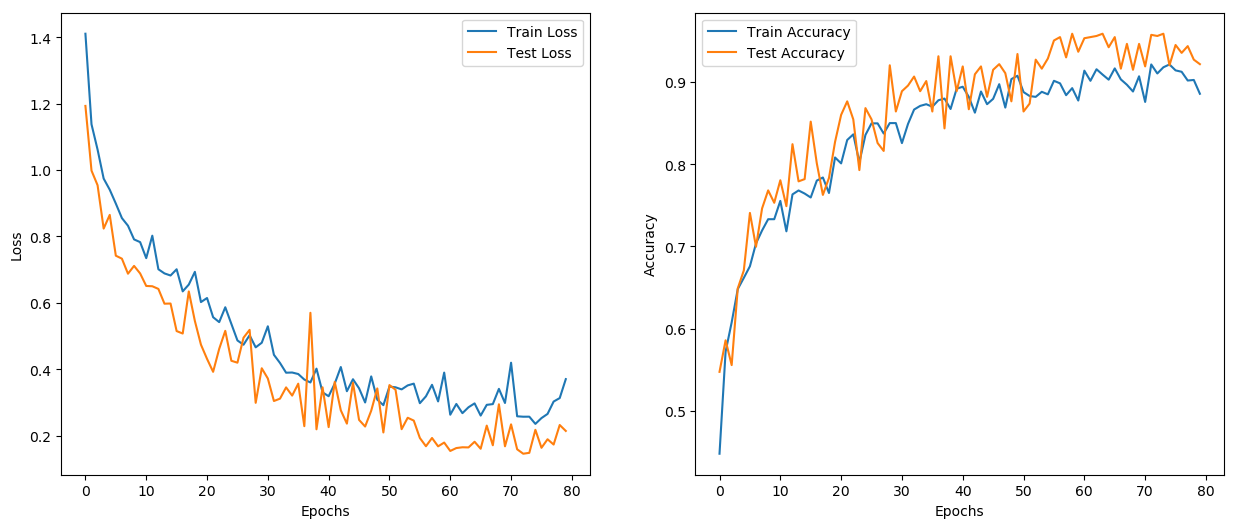

In [44]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.lineplot(x=range(epochs), y=train_losses, label='Train Loss')
sns.lineplot(x=range(epochs), y=test_losses, label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
sns.lineplot(x=range(epochs), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(epochs), y=test_accs, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [45]:
save_model(model, 'gnn.safetensors')